In [1]:
# import dependencies for nilmtk
from __future__ import print_function, division
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

# %matplotlib inline
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import FHMM
import nilmtk.utils
from daedisaggregator import DAEDisaggregator

Using TensorFlow backend.


In [2]:
train = DataSet('data/converted_maplewood_1sec.HDF')
test = DataSet('data/converted_maplewood_1sec.HDF')


In [3]:
nilmtk.utils.print_dict(train.metadata)

In [4]:
building_elec= train.buildings[1].elec
agg_power = building_elec[1]
agg_df = next(agg_power.load())
agg_df.head(10)


physical_quantity,power
type,active
timestamp,
2018-11-04 06:00:00-05:00,218.875
2018-11-04 06:00:01-05:00,220.875
2018-11-04 06:00:02-05:00,218.875
2018-11-04 06:00:03-05:00,221.375
2018-11-04 06:00:04-05:00,218.875
2018-11-04 06:00:05-05:00,220.375
2018-11-04 06:00:06-05:00,218.875
2018-11-04 06:00:06-05:00,219.875


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


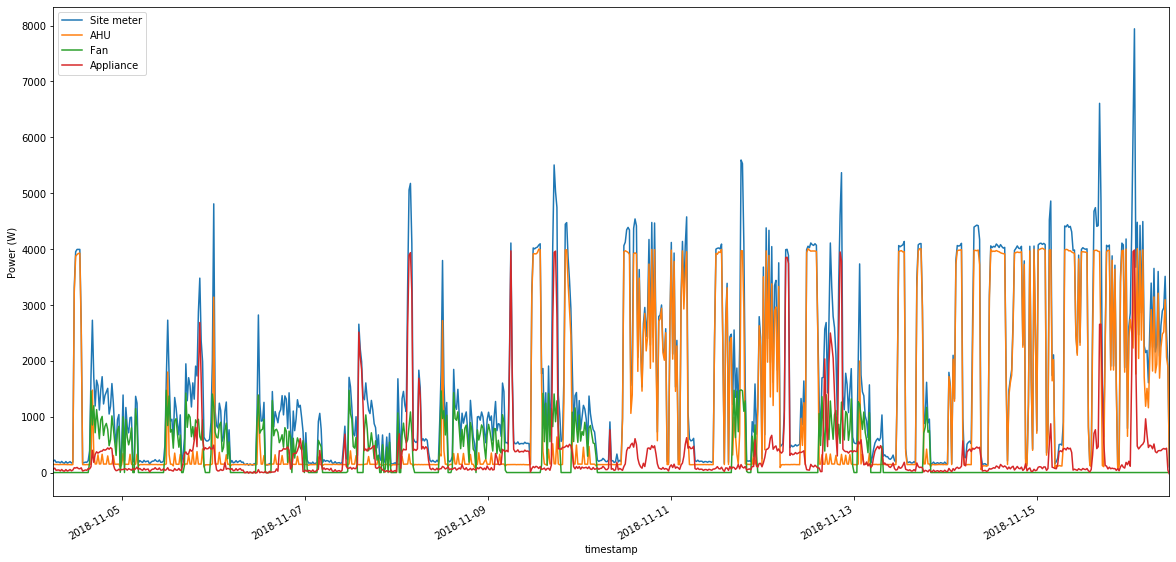

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
building_elec.plot()

In [6]:
building_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='Maplewood', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='Maplewood', appliances=[Appliance(type='AHU', instance=1)])
  ElecMeter(instance=3, building=1, dataset='Maplewood', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=4, building=1, dataset='Maplewood', appliances=[Appliance(type='appliance', instance=1)])
)

The above code are for sanity check that the conversion into compatible Dataset type is correct. 
Following is the disaggregation process. 
### NOTE:
One thing that I have noticed is that the values of power changed during the conversion into the HD5 format. 
It could be because I am assuming active power. Not too sure: problem is that there is no support for "real" power! How do I convert from reactive and active power?


In [7]:
# split up the training and testing set
train.set_window(end="2018-11-15")
test.set_window(start="2018-11-15")
training_main = train.buildings[1].elec.mains()
training_AHU = train.buildings[1].elec['AHU']

In [8]:
print(next(training_AHU.load()).head())
print(next(training_main.load()).head())

physical_quantity             power
type                         active
timestamp                          
2018-11-04 06:00:00-05:00  148.8275
2018-11-04 06:00:01-05:00  148.2375
2018-11-04 06:00:02-05:00  148.8275
2018-11-04 06:00:03-05:00  148.2375
2018-11-04 06:00:04-05:00  148.2375
physical_quantity            power
type                        active
timestamp                         
2018-11-04 06:00:00-05:00  218.875
2018-11-04 06:00:01-05:00  220.875
2018-11-04 06:00:02-05:00  218.875
2018-11-04 06:00:03-05:00  221.375
2018-11-04 06:00:04-05:00  218.875


In [9]:
# define a function for calculating metrics 
def mae(predicted, ground_truth):
    n_rows = predicted.shape[0]
    all_errors = abs(predicted.subtract(ground_truth))
    return all_errors.power.active.sum()/n_rows


In [10]:
testing_main = test.buildings[1].elec.mains()
testing_AHU = test.buildings[1].elec['AHU']

In [20]:
# Define a function to try multiple window sizes for the neural net
def run_experiment(smallest, biggest, step):
    print("running experiment for step: ", step)
    SAMPLE_PERIOD = 30
    error_dict = {}
    for win_size in range(smallest, biggest, step):
        print(win_size)
        WINDOW_SIZE = win_size
        dae = DAEDisaggregator(WINDOW_SIZE)
        dae.train(training_main, training_AHU, epochs=200, sample_period=SAMPLE_PERIOD)
        ex_model_name = "trained_models/model_unit1_AHU_30sec_window_"+str(WINDOW_SIZE)
        disagg_output_name = "disaggregated_model/dae_unit1_AHU_30sec_window"+str(WINDOW_SIZE)+".h5"
        dae.export_model(ex_model_name)
        DAEoutput = HDFDataStore(disagg_output_name, 'w')
        dae.disaggregate(testing_main, DAEoutput, testing_AHU, sample_period=SAMPLE_PERIOD)
        DAEresult = DataSet(disagg_output_name)
        pred = DAEresult.buildings[1].elec['AHU']
        pred_df = next(pred.load())
        gt_df = next(testing_AHU.load())
        error = mae(pred_df, gt_df)
        error_dict[WINDOW_SIZE] = error
    return error_dict
        
        

In [21]:
ed = run_experiment(5, 40, 5)

running experiment for step:  5
5


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
6193/6193 [==============================] - 2s 260us/step - loss: 0.0104
Epoch 2/200
6193/6193 [==============================] - 1s 180us/step - loss: 0.0085
Epoch 3/200
6193/6193 [==============================] - 1s 203us/step - loss: 0.0073
Epoch 4/200
6193/6193 [==============================] - 1s 190us/step - loss: 0.0066
Epoch 5/200
6193/6193 [==============================] - 1s 173us/step - loss: 0.0060
Epoch 6/200
6193/6193 [==============================] - 1s 177us/step - loss: 0.0057
Epoch 7/200
6193/6193 [==============================] - 1s 175us/step - loss: 0.0055
Epoch 8/200
6193/6193 [==============================] - 1s 176us/step - loss: 0.0053
Epoch 9/200
6193/6193 [==============================] - 1s 178us/step - loss: 0.0052
Epoch 10/200
6193/6193 [==============================] - 1s 177us/step - loss: 0.0051
Epoch 11/200
6193/6193 [==============================] - 1s 176us/step - loss: 0.0051
Epoch 12/200
6193/6193 [============================

6193/6193 [==============================] - 1s 171us/step - loss: 0.0039
Epoch 96/200
6193/6193 [==============================] - 1s 174us/step - loss: 0.0037
Epoch 97/200
6193/6193 [==============================] - 1s 176us/step - loss: 0.0039
Epoch 98/200
6193/6193 [==============================] - 1s 172us/step - loss: 0.0039
Epoch 99/200
6193/6193 [==============================] - 1s 184us/step - loss: 0.0038
Epoch 100/200
6193/6193 [==============================] - 1s 174us/step - loss: 0.0038
Epoch 101/200
6193/6193 [==============================] - 1s 170us/step - loss: 0.0038
Epoch 102/200
6193/6193 [==============================] - 1s 169us/step - loss: 0.0038
Epoch 103/200
6193/6193 [==============================] - 1s 169us/step - loss: 0.0038
Epoch 104/200
6193/6193 [==============================] - 1s 177us/step - loss: 0.0041
Epoch 105/200
6193/6193 [==============================] - 1s 182us/step - loss: 0.0040
Epoch 106/200
6193/6193 [=========================

6193/6193 [==============================] - 1s 182us/step - loss: 0.0037
Epoch 189/200
6193/6193 [==============================] - 1s 192us/step - loss: 0.0039
Epoch 190/200
6193/6193 [==============================] - 1s 186us/step - loss: 0.0037
Epoch 191/200
6193/6193 [==============================] - 1s 189us/step - loss: 0.0039
Epoch 192/200
6193/6193 [==============================] - 1s 190us/step - loss: 0.0036
Epoch 193/200
6193/6193 [==============================] - 1s 206us/step - loss: 0.0036
Epoch 194/200
6193/6193 [==============================] - 1s 189us/step - loss: 0.0038
Epoch 195/200
6193/6193 [==============================] - 1s 209us/step - loss: 0.0037
Epoch 196/200
6193/6193 [==============================] - 1s 220us/step - loss: 0.0037
Epoch 197/200
6193/6193 [==============================] - 1s 234us/step - loss: 0.0039
Epoch 198/200
6193/6193 [==============================] - 1s 235us/step - loss: 0.0037
Epoch 199/200
6193/6193 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


New sensible chunk: 4163
10


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
3097/3097 [==============================] - 1s 372us/step - loss: 0.0137
Epoch 2/200
3097/3097 [==============================] - 1s 256us/step - loss: 0.0108
Epoch 3/200
3097/3097 [==============================] - 1s 218us/step - loss: 0.0091
Epoch 4/200
3097/3097 [==============================] - 1s 218us/step - loss: 0.0082
Epoch 5/200
3097/3097 [==============================] - 1s 234us/step - loss: 0.0073
Epoch 6/200
3097/3097 [==============================] - 1s 215us/step - loss: 0.0069
Epoch 7/200
3097/3097 [==============================] - 1s 194us/step - loss: 0.0062
Epoch 8/200
3097/3097 [==============================] - 1s 199us/step - loss: 0.0058
Epoch 9/200
3097/3097 [==============================] - 1s 224us/step - loss: 0.0056
Epoch 10/200
3097/3097 [==============================] - 1s 217us/step - loss: 0.0057
Epoch 11/200
3097/3097 [==============================] - 1s 214us/step - loss: 0.0049
Epoch 12/200
3097/3097 [============================

3097/3097 [==============================] - 1s 201us/step - loss: 0.0036
Epoch 96/200
3097/3097 [==============================] - 1s 197us/step - loss: 0.0036
Epoch 97/200
3097/3097 [==============================] - 1s 202us/step - loss: 0.0034
Epoch 98/200
3097/3097 [==============================] - 1s 206us/step - loss: 0.0035
Epoch 99/200
3097/3097 [==============================] - 1s 206us/step - loss: 0.0036
Epoch 100/200
3097/3097 [==============================] - 1s 207us/step - loss: 0.0036
Epoch 101/200
3097/3097 [==============================] - 1s 212us/step - loss: 0.0036
Epoch 102/200
3097/3097 [==============================] - 1s 225us/step - loss: 0.0035
Epoch 103/200
3097/3097 [==============================] - 1s 206us/step - loss: 0.0034
Epoch 104/200
3097/3097 [==============================] - 1s 199us/step - loss: 0.0036
Epoch 105/200
3097/3097 [==============================] - 1s 205us/step - loss: 0.0037
Epoch 106/200
3097/3097 [=========================

3097/3097 [==============================] - 1s 246us/step - loss: 0.0033
Epoch 189/200
3097/3097 [==============================] - 1s 244us/step - loss: 0.0034
Epoch 190/200
3097/3097 [==============================] - 1s 232us/step - loss: 0.0032
Epoch 191/200
3097/3097 [==============================] - 1s 211us/step - loss: 0.0032
Epoch 192/200
3097/3097 [==============================] - 1s 222us/step - loss: 0.0031
Epoch 193/200
3097/3097 [==============================] - 1s 221us/step - loss: 0.0032
Epoch 194/200
3097/3097 [==============================] - 1s 214us/step - loss: 0.0032
Epoch 195/200
3097/3097 [==============================] - 1s 202us/step - loss: 0.0032
Epoch 196/200
3097/3097 [==============================] - 1s 195us/step - loss: 0.0032
Epoch 197/200
3097/3097 [==============================] - 1s 206us/step - loss: 0.0031
Epoch 198/200
3097/3097 [==============================] - 1s 215us/step - loss: 0.0033
Epoch 199/200
3097/3097 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


New sensible chunk: 4163
15


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
2065/2065 [==============================] - 1s 413us/step - loss: 0.0153
Epoch 2/200
2065/2065 [==============================] - 0s 237us/step - loss: 0.0111
Epoch 3/200
2065/2065 [==============================] - 1s 255us/step - loss: 0.0103
Epoch 4/200
2065/2065 [==============================] - 0s 239us/step - loss: 0.0092
Epoch 5/200
2065/2065 [==============================] - 0s 238us/step - loss: 0.0087
Epoch 6/200
2065/2065 [==============================] - 0s 229us/step - loss: 0.0081
Epoch 7/200
2065/2065 [==============================] - 0s 237us/step - loss: 0.0076
Epoch 8/200
2065/2065 [==============================] - 0s 241us/step - loss: 0.0076
Epoch 9/200
2065/2065 [==============================] - 1s 247us/step - loss: 0.0066
Epoch 10/200
2065/2065 [==============================] - 1s 244us/step - loss: 0.0066
Epoch 11/200
2065/2065 [==============================] - 0s 229us/step - loss: 0.0062
Epoch 12/200
2065/2065 [============================

2065/2065 [==============================] - 0s 220us/step - loss: 0.0036
Epoch 96/200
2065/2065 [==============================] - 0s 229us/step - loss: 0.0033
Epoch 97/200
2065/2065 [==============================] - 0s 224us/step - loss: 0.0034
Epoch 98/200
2065/2065 [==============================] - 0s 228us/step - loss: 0.0036
Epoch 99/200
2065/2065 [==============================] - 0s 225us/step - loss: 0.0036
Epoch 100/200
2065/2065 [==============================] - 0s 226us/step - loss: 0.0033
Epoch 101/200
2065/2065 [==============================] - 0s 224us/step - loss: 0.0036
Epoch 102/200
2065/2065 [==============================] - 0s 226us/step - loss: 0.0036
Epoch 103/200
2065/2065 [==============================] - 0s 222us/step - loss: 0.0035
Epoch 104/200
2065/2065 [==============================] - 0s 221us/step - loss: 0.0034
Epoch 105/200
2065/2065 [==============================] - 0s 230us/step - loss: 0.0037
Epoch 106/200
2065/2065 [=========================

2065/2065 [==============================] - 0s 223us/step - loss: 0.0031
Epoch 189/200
2065/2065 [==============================] - 0s 220us/step - loss: 0.0037
Epoch 190/200
2065/2065 [==============================] - 0s 218us/step - loss: 0.0035
Epoch 191/200
2065/2065 [==============================] - 0s 225us/step - loss: 0.0031
Epoch 192/200
2065/2065 [==============================] - 0s 219us/step - loss: 0.0032
Epoch 193/200
2065/2065 [==============================] - 0s 230us/step - loss: 0.0030
Epoch 194/200
2065/2065 [==============================] - 0s 230us/step - loss: 0.0030
Epoch 195/200
2065/2065 [==============================] - 0s 228us/step - loss: 0.0030
Epoch 196/200
2065/2065 [==============================] - 0s 231us/step - loss: 0.0030
Epoch 197/200
2065/2065 [==============================] - 0s 228us/step - loss: 0.0030
Epoch 198/200
2065/2065 [==============================] - 0s 232us/step - loss: 0.0031
Epoch 199/200
2065/2065 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


20


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
1549/1549 [==============================] - 1s 467us/step - loss: 0.0141
Epoch 2/200
1549/1549 [==============================] - 0s 252us/step - loss: 0.0110
Epoch 3/200
1549/1549 [==============================] - 0s 249us/step - loss: 0.0101
Epoch 4/200
1549/1549 [==============================] - 0s 243us/step - loss: 0.0095
Epoch 5/200
1549/1549 [==============================] - 0s 259us/step - loss: 0.0091
Epoch 6/200
1549/1549 [==============================] - 0s 260us/step - loss: 0.0085
Epoch 7/200
1549/1549 [==============================] - 0s 244us/step - loss: 0.0077
Epoch 8/200
1549/1549 [==============================] - 0s 242us/step - loss: 0.0074
Epoch 9/200
1549/1549 [==============================] - 0s 247us/step - loss: 0.0065
Epoch 10/200
1549/1549 [==============================] - 0s 247us/step - loss: 0.0064
Epoch 11/200
1549/1549 [==============================] - 0s 264us/step - loss: 0.0066
Epoch 12/200
1549/1549 [============================

1549/1549 [==============================] - 0s 257us/step - loss: 0.0030
Epoch 96/200
1549/1549 [==============================] - 0s 250us/step - loss: 0.0029
Epoch 97/200
1549/1549 [==============================] - 0s 249us/step - loss: 0.0032
Epoch 98/200
1549/1549 [==============================] - 0s 251us/step - loss: 0.0029
Epoch 99/200
1549/1549 [==============================] - 0s 251us/step - loss: 0.0031
Epoch 100/200
1549/1549 [==============================] - 0s 247us/step - loss: 0.0031
Epoch 101/200
1549/1549 [==============================] - 0s 244us/step - loss: 0.0031
Epoch 102/200
1549/1549 [==============================] - 0s 248us/step - loss: 0.0029
Epoch 103/200
1549/1549 [==============================] - 0s 258us/step - loss: 0.0027
Epoch 104/200
1549/1549 [==============================] - 0s 254us/step - loss: 0.0029
Epoch 105/200
1549/1549 [==============================] - 0s 250us/step - loss: 0.0029
Epoch 106/200
1549/1549 [=========================

1549/1549 [==============================] - 0s 245us/step - loss: 0.0025
Epoch 188/200
1549/1549 [==============================] - 0s 245us/step - loss: 0.0027
Epoch 189/200
1549/1549 [==============================] - 0s 246us/step - loss: 0.0026
Epoch 190/200
1549/1549 [==============================] - 0s 246us/step - loss: 0.0027
Epoch 191/200
1549/1549 [==============================] - 0s 244us/step - loss: 0.0027
Epoch 192/200
1549/1549 [==============================] - 0s 244us/step - loss: 0.0026
Epoch 193/200
1549/1549 [==============================] - 0s 246us/step - loss: 0.0025
Epoch 194/200
1549/1549 [==============================] - 0s 248us/step - loss: 0.0025
Epoch 195/200
1549/1549 [==============================] - 0s 251us/step - loss: 0.0025
Epoch 196/200
1549/1549 [==============================] - 0s 251us/step - loss: 0.0025
Epoch 197/200
1549/1549 [==============================] - 0s 244us/step - loss: 0.0026
Epoch 198/200
1549/1549 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


25


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
1239/1239 [==============================] - 1s 541us/step - loss: 0.0154
Epoch 2/200
1239/1239 [==============================] - 0s 266us/step - loss: 0.0117
Epoch 3/200
1239/1239 [==============================] - 0s 268us/step - loss: 0.0116
Epoch 4/200
1239/1239 [==============================] - 0s 260us/step - loss: 0.0109
Epoch 5/200
1239/1239 [==============================] - 0s 278us/step - loss: 0.0109
Epoch 6/200
1239/1239 [==============================] - 0s 276us/step - loss: 0.0095
Epoch 7/200
1239/1239 [==============================] - 0s 260us/step - loss: 0.0092
Epoch 8/200
1239/1239 [==============================] - 0s 252us/step - loss: 0.0083
Epoch 9/200
1239/1239 [==============================] - 0s 267us/step - loss: 0.0077
Epoch 10/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0076
Epoch 11/200
1239/1239 [==============================] - 0s 258us/step - loss: 0.0071
Epoch 12/200
1239/1239 [============================

1239/1239 [==============================] - 0s 260us/step - loss: 0.0027
Epoch 96/200
1239/1239 [==============================] - 0s 260us/step - loss: 0.0027
Epoch 97/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0027
Epoch 98/200
1239/1239 [==============================] - 0s 255us/step - loss: 0.0027
Epoch 99/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0026
Epoch 100/200
1239/1239 [==============================] - 0s 251us/step - loss: 0.0026
Epoch 101/200
1239/1239 [==============================] - 0s 261us/step - loss: 0.0028
Epoch 102/200
1239/1239 [==============================] - 0s 255us/step - loss: 0.0029
Epoch 103/200
1239/1239 [==============================] - 0s 256us/step - loss: 0.0027
Epoch 104/200
1239/1239 [==============================] - 0s 259us/step - loss: 0.0029
Epoch 105/200
1239/1239 [==============================] - 0s 255us/step - loss: 0.0025
Epoch 106/200
1239/1239 [=========================

1239/1239 [==============================] - 0s 260us/step - loss: 0.0020
Epoch 189/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0021
Epoch 190/200
1239/1239 [==============================] - 0s 252us/step - loss: 0.0023
Epoch 191/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0025
Epoch 192/200
1239/1239 [==============================] - 0s 254us/step - loss: 0.0020
Epoch 193/200
1239/1239 [==============================] - 0s 258us/step - loss: 0.0024
Epoch 194/200
1239/1239 [==============================] - 0s 256us/step - loss: 0.0020
Epoch 195/200
1239/1239 [==============================] - 0s 250us/step - loss: 0.0021
Epoch 196/200
1239/1239 [==============================] - 0s 256us/step - loss: 0.0020
Epoch 197/200
1239/1239 [==============================] - 0s 250us/step - loss: 0.0019
Epoch 198/200
1239/1239 [==============================] - 0s 265us/step - loss: 0.0020
Epoch 199/200
1239/1239 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


30


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
1033/1033 [==============================] - 1s 609us/step - loss: 0.0183
Epoch 2/200
1033/1033 [==============================] - 0s 306us/step - loss: 0.0117
Epoch 3/200
1033/1033 [==============================] - 0s 310us/step - loss: 0.0112
Epoch 4/200
1033/1033 [==============================] - 0s 286us/step - loss: 0.0104
Epoch 5/200
1033/1033 [==============================] - 0s 299us/step - loss: 0.0098
Epoch 6/200
1033/1033 [==============================] - 0s 318us/step - loss: 0.0088
Epoch 7/200
1033/1033 [==============================] - 0s 330us/step - loss: 0.0091
Epoch 8/200
1033/1033 [==============================] - 0s 284us/step - loss: 0.0088
Epoch 9/200
1033/1033 [==============================] - 0s 300us/step - loss: 0.0077
Epoch 10/200
1033/1033 [==============================] - 0s 291us/step - loss: 0.0075
Epoch 11/200
1033/1033 [==============================] - 0s 293us/step - loss: 0.0071
Epoch 12/200
1033/1033 [============================

1033/1033 [==============================] - 0s 276us/step - loss: 0.0026
Epoch 96/200
1033/1033 [==============================] - 0s 275us/step - loss: 0.0024
Epoch 97/200
1033/1033 [==============================] - 0s 285us/step - loss: 0.0024
Epoch 98/200
1033/1033 [==============================] - 0s 275us/step - loss: 0.0021
Epoch 99/200
1033/1033 [==============================] - 0s 276us/step - loss: 0.0023
Epoch 100/200
1033/1033 [==============================] - 0s 281us/step - loss: 0.0027
Epoch 101/200
1033/1033 [==============================] - 0s 291us/step - loss: 0.0024
Epoch 102/200
1033/1033 [==============================] - 0s 291us/step - loss: 0.0024
Epoch 103/200
1033/1033 [==============================] - 0s 291us/step - loss: 0.0024
Epoch 104/200
1033/1033 [==============================] - 0s 273us/step - loss: 0.0024
Epoch 105/200
1033/1033 [==============================] - 0s 276us/step - loss: 0.0023
Epoch 106/200
1033/1033 [=========================

1033/1033 [==============================] - 0s 278us/step - loss: 0.0020
Epoch 189/200
1033/1033 [==============================] - 0s 269us/step - loss: 0.0020
Epoch 190/200
1033/1033 [==============================] - 0s 272us/step - loss: 0.0021
Epoch 191/200
1033/1033 [==============================] - 0s 278us/step - loss: 0.0021
Epoch 192/200
1033/1033 [==============================] - 0s 287us/step - loss: 0.0019
Epoch 193/200
1033/1033 [==============================] - 0s 285us/step - loss: 0.0019
Epoch 194/200
1033/1033 [==============================] - 0s 269us/step - loss: 0.0020
Epoch 195/200
1033/1033 [==============================] - 0s 275us/step - loss: 0.0021
Epoch 196/200
1033/1033 [==============================] - 0s 277us/step - loss: 0.0020
Epoch 197/200
1033/1033 [==============================] - 0s 284us/step - loss: 0.0021
Epoch 198/200
1033/1033 [==============================] - 0s 290us/step - loss: 0.0020
Epoch 199/200
1033/1033 [=====================

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


35


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


Epoch 1/200
885/885 [==============================] - 1s 712us/step - loss: 0.0188
Epoch 2/200
885/885 [==============================] - 0s 317us/step - loss: 0.0132
Epoch 3/200
885/885 [==============================] - 0s 309us/step - loss: 0.0111
Epoch 4/200
885/885 [==============================] - 0s 313us/step - loss: 0.0114
Epoch 5/200
885/885 [==============================] - 0s 315us/step - loss: 0.0095
Epoch 6/200
885/885 [==============================] - 0s 319us/step - loss: 0.0100
Epoch 7/200
885/885 [==============================] - 0s 311us/step - loss: 0.0101
Epoch 8/200
885/885 [==============================] - 0s 291us/step - loss: 0.0088
Epoch 9/200
885/885 [==============================] - 0s 300us/step - loss: 0.0095
Epoch 10/200
885/885 [==============================] - 0s 283us/step - loss: 0.0086
Epoch 11/200
885/885 [==============================] - 0s 287us/step - loss: 0.0088
Epoch 12/200
885/885 [==============================] - 0s 281us/step - lo

Epoch 97/200
885/885 [==============================] - 0s 291us/step - loss: 0.0026
Epoch 98/200
885/885 [==============================] - 0s 294us/step - loss: 0.0026
Epoch 99/200
885/885 [==============================] - 0s 293us/step - loss: 0.0028
Epoch 100/200
885/885 [==============================] - 0s 286us/step - loss: 0.0028
Epoch 101/200
885/885 [==============================] - 0s 293us/step - loss: 0.0025
Epoch 102/200
885/885 [==============================] - 0s 291us/step - loss: 0.0027
Epoch 103/200
885/885 [==============================] - 0s 293us/step - loss: 0.0025
Epoch 104/200
885/885 [==============================] - 0s 286us/step - loss: 0.0026
Epoch 105/200
885/885 [==============================] - 0s 297us/step - loss: 0.0025
Epoch 106/200
885/885 [==============================] - 0s 288us/step - loss: 0.0024
Epoch 107/200
885/885 [==============================] - 0s 293us/step - loss: 0.0024
Epoch 108/200
885/885 [==============================] - 

885/885 [==============================] - 0s 326us/step - loss: 0.0019
Epoch 192/200
885/885 [==============================] - 0s 318us/step - loss: 0.0019
Epoch 193/200
885/885 [==============================] - 0s 331us/step - loss: 0.0021
Epoch 194/200
885/885 [==============================] - 0s 310us/step - loss: 0.0023
Epoch 195/200
885/885 [==============================] - 0s 308us/step - loss: 0.0020
Epoch 196/200
885/885 [==============================] - 0s 329us/step - loss: 0.0018
Epoch 197/200
885/885 [==============================] - 0s 329us/step - loss: 0.0022
Epoch 198/200
885/885 [==============================] - 0s 319us/step - loss: 0.0023
Epoch 199/200
885/885 [==============================] - 0s 319us/step - loss: 0.0021
Epoch 200/200
885/885 [==============================] - 0s 310us/step - loss: 0.0021
New sensible chunk: 4163


d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


In [22]:
ed

{5: 360.7024081876356,
 10: 282.30450921652124,
 15: 308.9678296404165,
 20: 388.59721094968023,
 25: 354.29959582457263,
 30: 355.4180511325998,
 35: 444.74960685156975}

In [15]:
# dae.train(training_main, training_AHU, epochs=800, sample_period=300)

In [16]:
# ex_model_name = "model_unit1_interval5"
# disagg_output_name = "dae_unit1_interval5_out.h5"
# dae.export_model(ex_model_name)
# dae_disagg_output_name = disagg_output_name
# DAEoutput = HDFDataStore(dae_disagg_output_name, 'w')

In [17]:
# testing_main = test.buildings[1].elec.mains()
# testing_AHU = test.buildings[1].elec['AHU']
# dae.disaggregate(testing_main, DAEoutput, testing_AHU, sample_period=SAMPLE_PERIOD)
# DAEresult = DataSet(dae_disagg_output_name)

d:\zhilong documents\fall 2019\energy disaggregation\energy_disaggregation\venv\lib\site-packages\nilmtk\utils.py:507: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


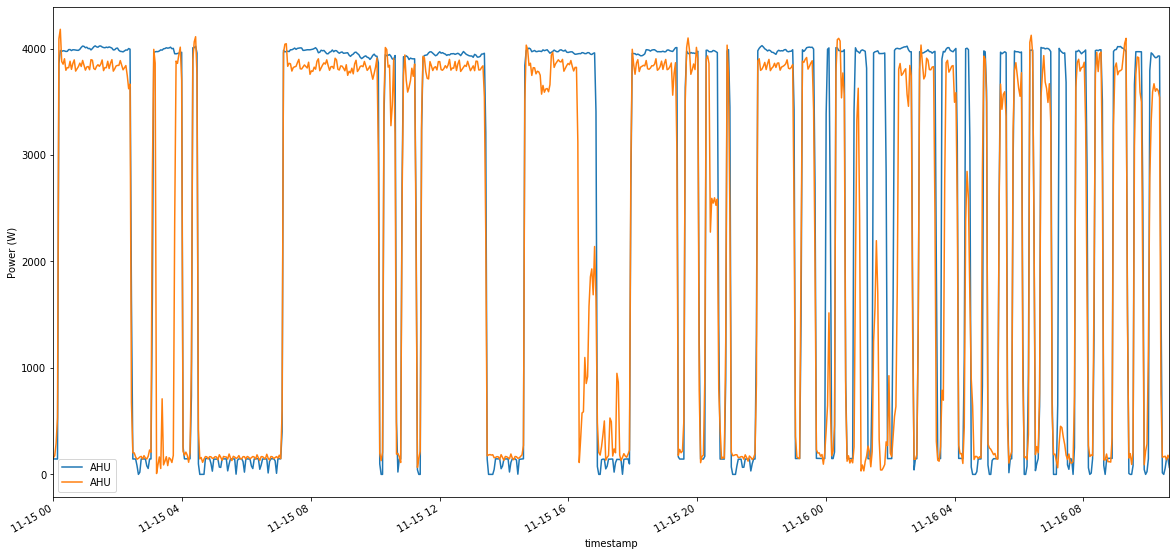

In [26]:
testing_AHU.plot()
DAEresult = DataSet('disaggregated_model/dae_unit1_AHU_30sec_window35.h5')
pred = DAEresult.buildings[1].elec['AHU']
pred.plot()
plt.savefig('plots/window35_30_sec_AHU')


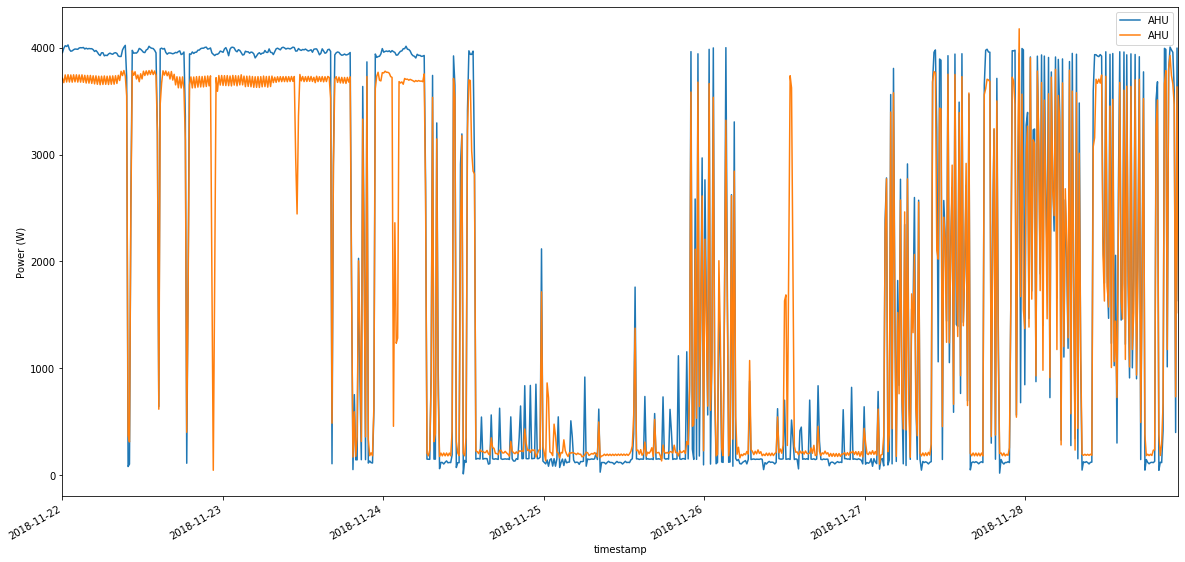

In [15]:
DAEresult = DataSet('disaggregated_model/dae_unit1_AHU_out_window5.h5')
testing_AHU.plot()
pred = DAEresult.buildings[1].elec['AHU']
pred.plot()
plt.savefig('plots/window5_AHU')

In [20]:
# pred_df = next(pred.load())
# gt_df = next(testing_AHU.load())
# # print(pred_df.head())
# # print(gt_df.head())
# res = pred_df.subtract(gt_df)
# print(mae(pred_df, gt_df))

Results for AHU is not too bad! Can play around with a permutation of hyperparamters (sample period, window size) to figure out whats the optimal.